# Data exploration - Swap transactions for the top Rollups

#### Maria Silva, August 2024

In [1]:
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.neighbors import KernelDensity

In [2]:
data_dir = os.path.realpath(os.path.join(os.getcwd(), "..", "data"))

In [3]:
paper_template = dict(
    layout=go.Layout(
        template="simple_white",
        font=dict(size=14, family="Clear Sans"),
        margin=go.layout.Margin(
            l=40,  # left margin
            r=40,  # right margin
            b=40,  # bottom margin
            t=40,  # top margin
        ),
        width=700,
        xaxis=dict(
            automargin=True, minor_ticks="inside", showgrid=True, griddash="dash", minor_griddash="dot"
        ),
        yaxis=dict(
            automargin=True, minor_ticks="inside", showgrid=True, griddash="dash", minor_griddash="dot"
        ),
        )
)

## Load and clean data

In [4]:
file_path = os.path.join(data_dir, "dune_success_swaps.csv")
raw_swap_txs_df = pd.read_csv(file_path, low_memory=False)
raw_swap_txs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3892383 entries, 0 to 3892382
Data columns (total 15 columns):
 #   Column               Dtype  
---  ------               -----  
 0   block_time           object 
 1   blockchain           object 
 2   effective_gas_price  float64
 3   evt_index            int64  
 4   gas_used             int64  
 5   project              object 
 6   token_bought_amount  float64
 7   token_bought_symbol  object 
 8   token_pair           object 
 9   token_sold_amount    float64
 10  token_sold_symbol    object 
 11  tx_hash              object 
 12  tx_receiver          object 
 13  tx_sender            object 
 14  version              object 
dtypes: float64(3), int64(2), object(10)
memory usage: 445.4+ MB


In [5]:
swaps_per_tx = raw_swap_txs_df.groupby("tx_hash").size().reset_index()
swap_txs_df = raw_swap_txs_df.merge(swaps_per_tx, on="tx_hash", how="left")
swap_txs_df = swap_txs_df.rename(columns={0:"swaps_per_tx"})

swap_txs_df["gas_units_per_swap"] = swap_txs_df["gas_used"]/swap_txs_df["swaps_per_tx"]
swap_txs_df["block_time"] = pd.to_datetime(swap_txs_df["block_time"])

swap_txs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3892383 entries, 0 to 3892382
Data columns (total 17 columns):
 #   Column               Dtype              
---  ------               -----              
 0   block_time           datetime64[ns, UTC]
 1   blockchain           object             
 2   effective_gas_price  float64            
 3   evt_index            int64              
 4   gas_used             int64              
 5   project              object             
 6   token_bought_amount  float64            
 7   token_bought_symbol  object             
 8   token_pair           object             
 9   token_sold_amount    float64            
 10  token_sold_symbol    object             
 11  tx_hash              object             
 12  tx_receiver          object             
 13  tx_sender            object             
 14  version              object             
 15  swaps_per_tx         int64              
 16  gas_units_per_swap   float64            
dtypes: datet

## Top projects and tokens

In [6]:
# Number of swaps per rollup
swap_txs_df.groupby("blockchain").size()

blockchain
arbitrum    1140728
base        2336566
optimism     333439
zksync        81650
dtype: int64

In [7]:
# Top projects per blockchain
(
    swap_txs_df
    .groupby(["blockchain", "project", "version"])
    .size()
    .reset_index()
    .sort_values(0, ascending=False)
    .groupby("blockchain")
    .head(5)
    .sort_values(["blockchain", 0], ascending=False)
)

,blockchain,project,version,0
122,zksync,pancakeswap,3,27798
124,zksync,syncswap,1,24196
119,zksync,maverick,1,11131
131,zksync,zkswap_finance,1,7571
120,zksync,mute,1,3339
107,optimism,uniswap,3,193614
109,optimism,velodrome,2,81953
100,optimism,solidly,3,17653
108,optimism,velodrome,1,13945
86,optimism,balancer,2,7562


In [8]:
# Top token pairs (overall)
(
    swap_txs_df
    .groupby(["token_pair"])
    .size()
    .reset_index()
    .sort_values(0, ascending=False)
    .head(15)
)

,token_pair,0
6551,USDC-WETH,720261
6633,USDT-WETH,213566
6663,USDbC-WETH,104731
6520,USDC-USDT,78630
726,ARB-USDC,73291
6811,WBTC-WETH,64518
736,ARB-WETH,63087
1424,BOYS-WETH,55032
443,AERO-USDC,52776
6547,USDC-WBTC,50377


In [9]:
# Top token pairs per blockchain
(
    swap_txs_df
    .groupby(["blockchain", "token_pair"])
    .size()
    .reset_index()
    .sort_values(0, ascending=False)
    .groupby("blockchain")
    .head(5)
    .sort_values(["blockchain", 0], ascending=False)
)

,blockchain,token_pair,0
8313,zksync,USDC-WETH,33417
8233,zksync,HOLD-WETH,11481
8331,zksync,USDT-WETH,9315
8309,zksync,USDC-USDT,2584
8341,zksync,WBTC-WETH,2494
7987,optimism,USDC-WETH,58246
7988,optimism,USDC-WLD,38028
7877,optimism,OP-WETH,28193
7985,optimism,USDC-VELO,20049
7977,optimism,USDC-USDC,16449


## Swaps per transaction

In [10]:
(
    swap_txs_df
    .groupby("blockchain")
    ["swaps_per_tx"]
    .agg(["mean", "std", "median", "min", "max"])
)

,mean,std,median,min,max
blockchain,,,,,
arbitrum,2.327103,3.789465,1.0,1,88
base,2.895572,11.845906,1.0,1,449
optimism,4.171681,8.278828,3.0,1,105
zksync,2.982952,4.026393,1.0,1,43


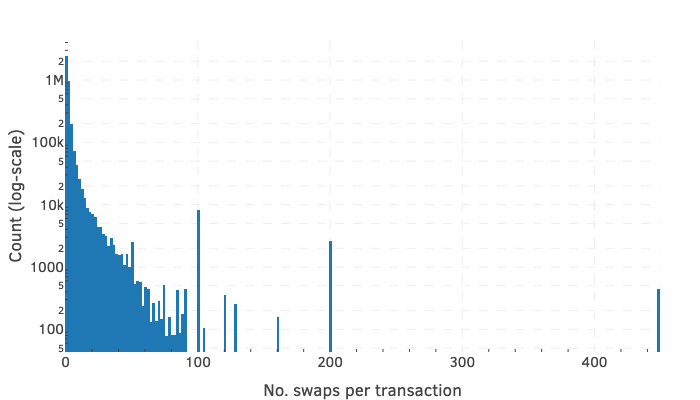

In [11]:
# Overall distribution
fig = px.histogram(swap_txs_df, x="swaps_per_tx", nbins=400, template=paper_template, 
                   height=400,log_y=True)
fig.update_layout(xaxis_title="No. swaps per transaction", yaxis_title="Count (log-scale)")
fig.show('png')

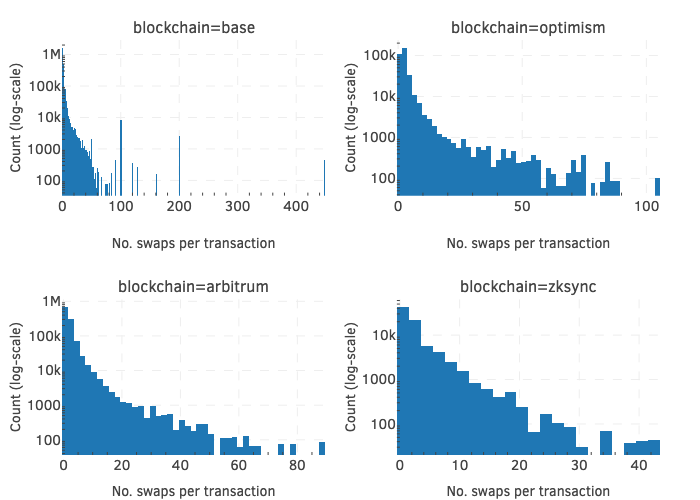

In [12]:
# Distribution per blockchain
fig = px.histogram(swap_txs_df, x="swaps_per_tx", nbins=400, template=paper_template,log_y=True,
                   facet_col="blockchain", facet_col_wrap=2, facet_row_spacing=0.25, facet_col_spacing=0.12,
                   category_orders={"blockchain": ["base", "optimism", "arbitrum", "zksync"]})
fig.update_xaxes(matches=None, showticklabels=True, title_text="No. swaps per transaction", title_font_size=14)
fig.update_yaxes(matches=None, showticklabels=True, title_text="Count (log-scale)", title_font_size=14)
fig.update_annotations(font_size=16)
fig.show('png')

## Gas usage

In [13]:
# Gas units per swap (total units in tx divided by no. of swaps)
(
    swap_txs_df
    .groupby("blockchain")
    ["gas_units_per_swap"]
    .agg(["mean", "std", "median", "min", "max"])
    .round(2)
)

,mean,std,median,min,max
blockchain,,,,,
arbitrum,265676.74,235562.76,211937.0,22624.63,27357351.0
base,168582.58,127370.89,130834.0,43731.34,7959915.0
optimism,226824.49,240066.08,153157.0,43340.20,5024050.0
zksync,213514.73,108028.66,192496.0,58102.00,4814637.0


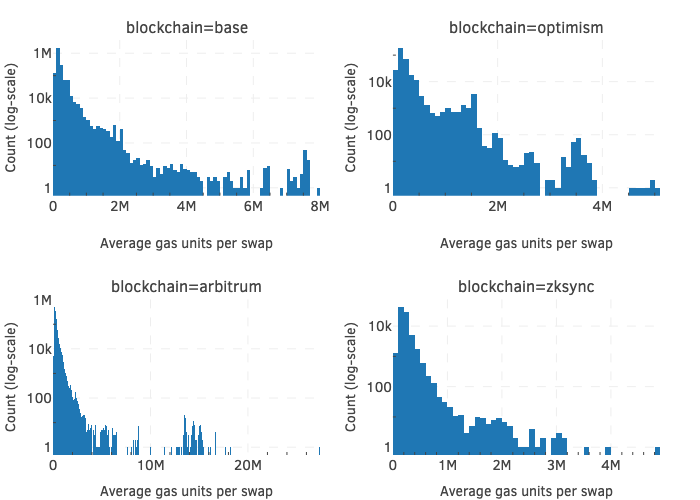

In [14]:
# Gas units per swap - Distribution per blockchain
fig = px.histogram(swap_txs_df, x="gas_units_per_swap", nbins=400, template=paper_template,log_y=True,
                   facet_col="blockchain", facet_col_wrap=2, facet_row_spacing=0.25, facet_col_spacing=0.12,
                   category_orders={"blockchain": ["base", "optimism", "arbitrum", "zksync"]})
fig.update_xaxes(matches=None, showticklabels=True, title_text="Average gas units per swap", title_font_size=14)
fig.update_yaxes(matches=None, showticklabels=True, title_text="Count (log-scale)", title_font_size=14)
fig.update_annotations(font_size=16)
fig.show('png')

In [15]:
# Gas units per swap by project
(
    swap_txs_df
    .groupby(["project", "version"])
    ["gas_units_per_swap"]
    .agg(["mean", "std", "median", "min", "max", "count"])
    .sort_values("count", ascending=False)
    .round(2)
    .head(15)
)

mean        std     median       min         max  \
project     version                                                             
uniswap     2           133986.17   61878.16  120786.00  38474.95   5890290.0   
            3           215637.54  233941.44  161200.00  34730.86  21769565.0   
pancakeswap 3           253739.66  169025.48  206783.75  22624.63   8748721.0   
aerodrome   1           290970.56  131346.66  257919.67  44858.40   7684170.0   
camelot     3           304662.18  167869.71  294816.42  36015.55   8014450.0   
aerodrome   slipstream  205029.53  172837.94  168145.00  68098.25   5244058.0   
velodrome   2           278415.17  175609.80  284619.00  80951.75   4886455.0   
ramses      2           269044.10  214105.61  224760.78  71721.25  27357351.0   
maverick    2           202174.45  135153.56  175001.55  76864.50   5391486.0   
solidly     3           185402.83  140510.07  147895.00  36015.55   5039320.0   
baseswap    1           157144.69   78901.28  131999.00  51889.36   4056776.0   
maverick    1           198222.25  118207.35  165194.33  73650.43   3110478.0   
sushiswap   1           244337.11  224706.72  159227.67  39925.00   7502890.0   
trader_joe  2.1         250365.10  678053.37  187051.10  22624.63  15305646.0   
balancer    2           249815.03  199074.96  196226.50  41253.45   3216956.0   

                          count  
project     version              
uniswap     2           1368946  
            3            943423  
pancakeswap 3            446590  
aerodrome   1            236250  
camelot     3            210048  
aerodrome   slipstream   123533  
velodrome   2             81953  
ramses      2             61229  
maverick    2             49089  
solidly     3             48734  
baseswap    1             45002  
maverick    1             40964  
sushiswap   1             40773  
trader_joe  2.1           35628  
balancer    2             26918

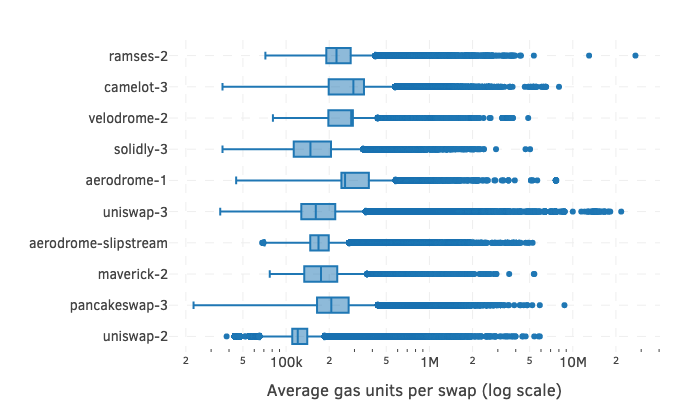

In [16]:
top_projects = (
    swap_txs_df
    .groupby(["project", "version"])
    .size()
    .sort_values(ascending=False)
    .iloc[:10]
    .reset_index()
    [["project", "version"]]
)
temp_df = swap_txs_df.merge(top_projects, how="inner", on=["project", "version"])
temp_df["project"] = temp_df["project"] + "-" + temp_df["version"]

fig = px.box(temp_df, y="project", x="gas_units_per_swap", template=paper_template, height=400, log_x=True)
fig.update_layout(xaxis_title="Average gas units per swap (log scale)", yaxis_title="")
fig.show('png')